# Questions

*   How to make the output of the trasnformer be adataframe?
*   why use  cross_val_score and not cross_validate?



##Loading the Data and EDA

###Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path
%matplotlib inline

###Loading the Data

In [75]:
# File Paths
X_train_Filename = csv_drive_path_generatoer('https://drive.google.com/file/d/1BcNd5fvzY_wSp9RSEp9pgsllko24RZef/view?usp=sharing')#"/content/X_train.csv"
y_train_Filename = csv_drive_path_generatoer('https://drive.google.com/file/d/10FfNimLrCSOQEQlPdf5UlKhXerJ_oYuF/view?usp=sharing')#"/content/y_train.csv"
X_test_Filename  = csv_drive_path_generatoer('https://drive.google.com/file/d/17yXAAn592_UPQNAvWhoQ6mKfpTn-AWf0/view?usp=sharing')#"/content/X_test.csv"

# Load the Train dataset
X_train = pd.read_csv(X_train_Filename)
y_train = pd.read_csv(y_train_Filename)

# Load the Test dataset
X_test = pd.read_csv(X_test_Filename)

# Set 'Unnamed: 0' as the index for X_train and y_train (will be useful later for lines removal)
X_train.set_index('Unnamed: 0', inplace=True)
y_train.set_index('Unnamed: 0', inplace=True)

X_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
Unnamed: 0,,,,,,,,,,
1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,1847,white
2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,2905,white
4610,Bachelors,2015,Pune,3,26.0,Female,No,2,4610,white
2228,Bachelors,2012,Bangalore,3,29.0,Male,No,1,2228,black
5,Bachelors,2016,Bangalore,3,24.0,Male,No,0,5,white


###EDA

Performing EDA for both X_Test and X_Train and compare between them to see if they similar

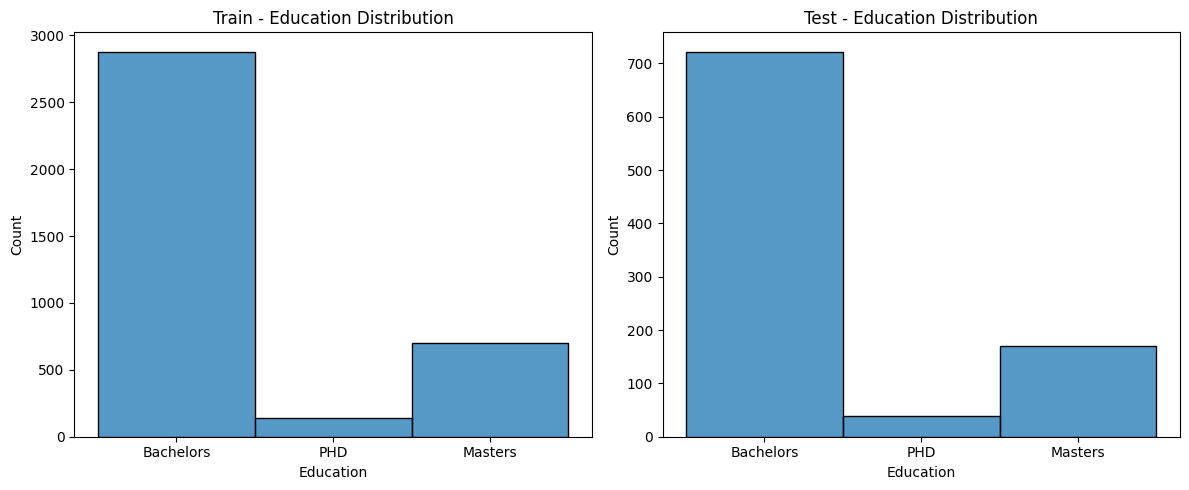

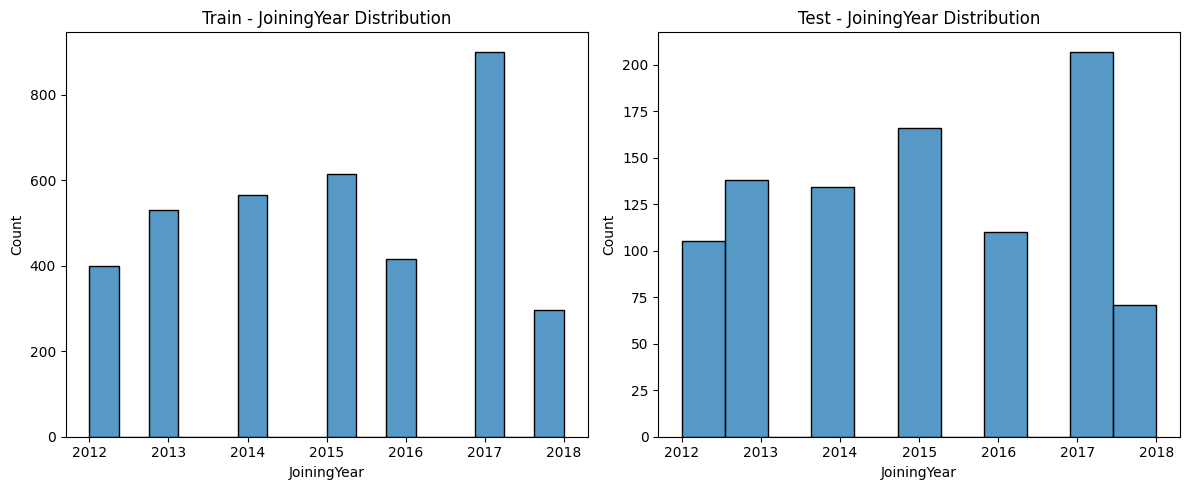

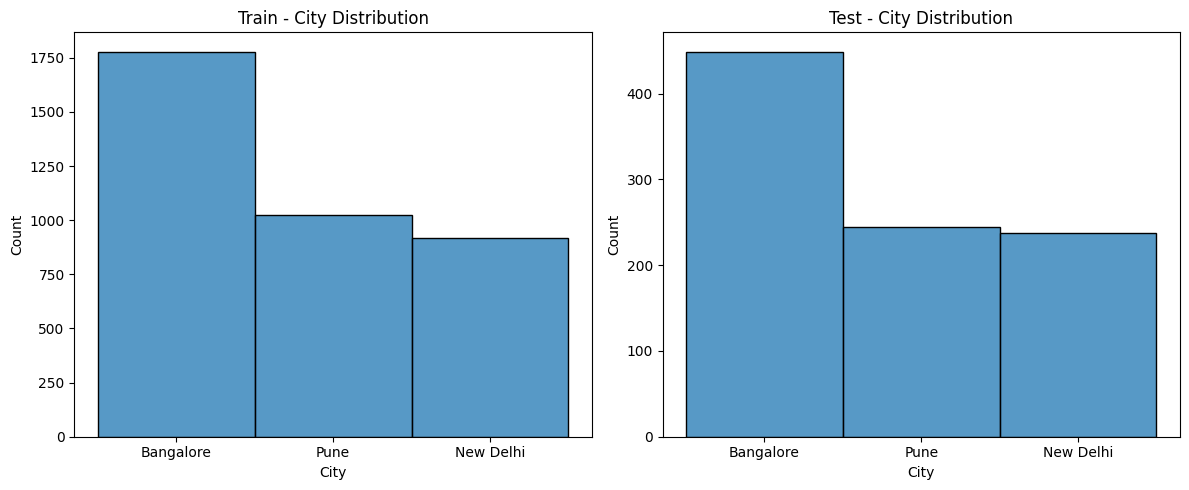

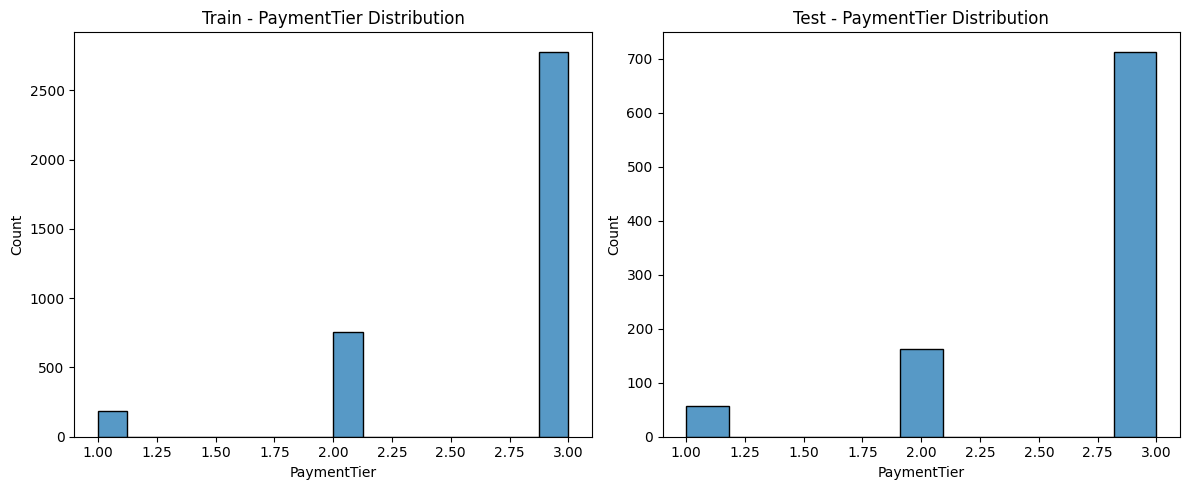

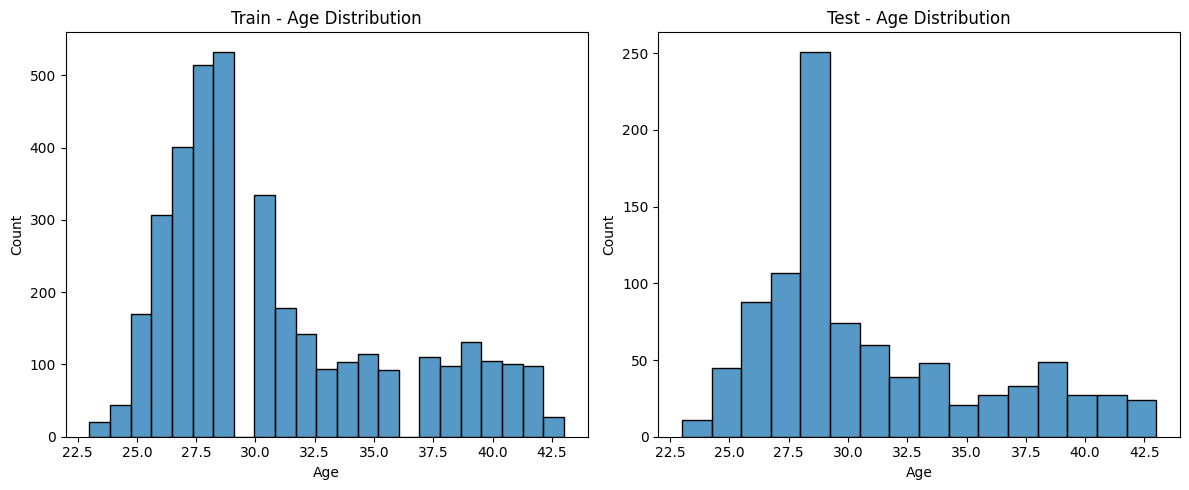

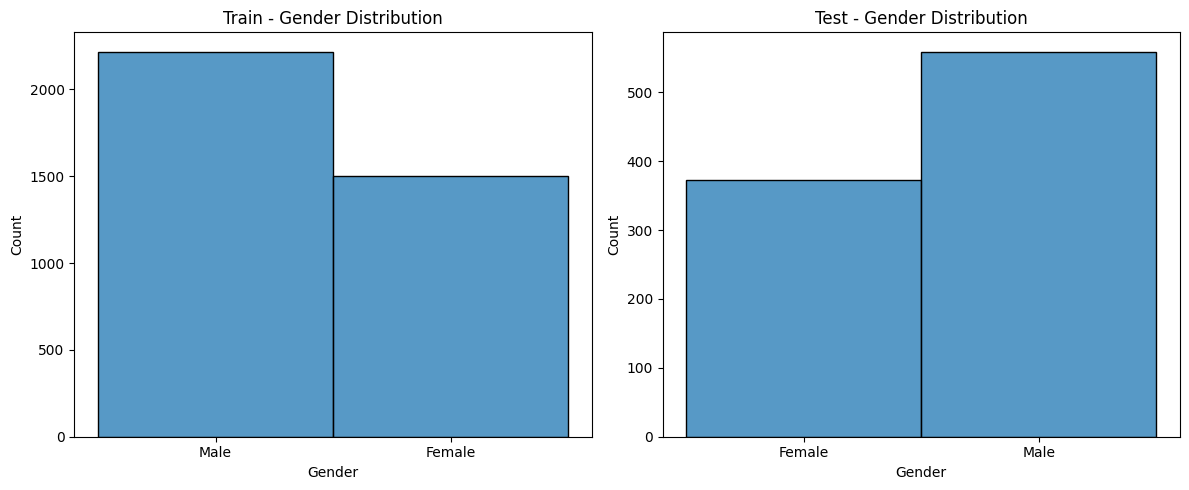

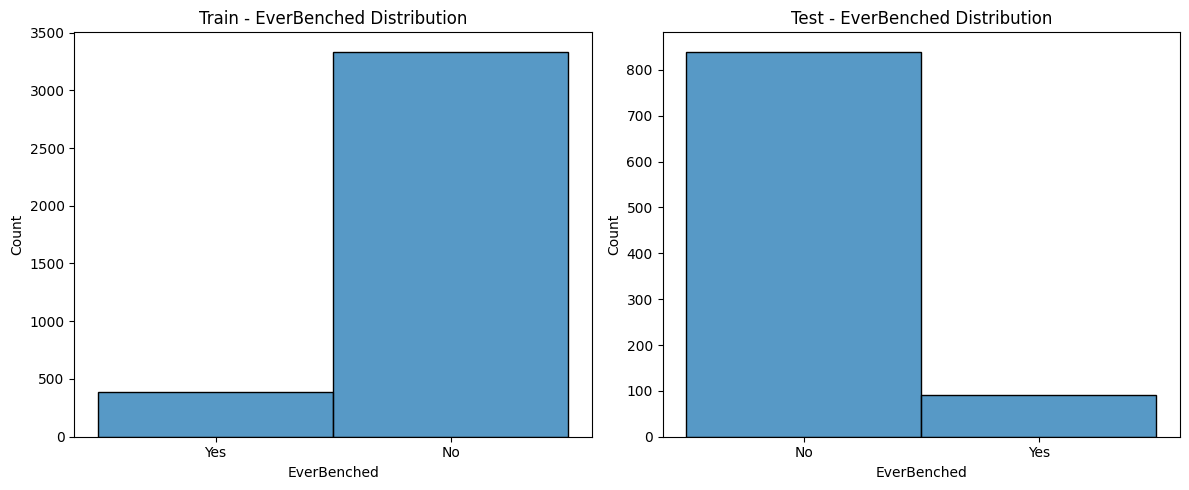

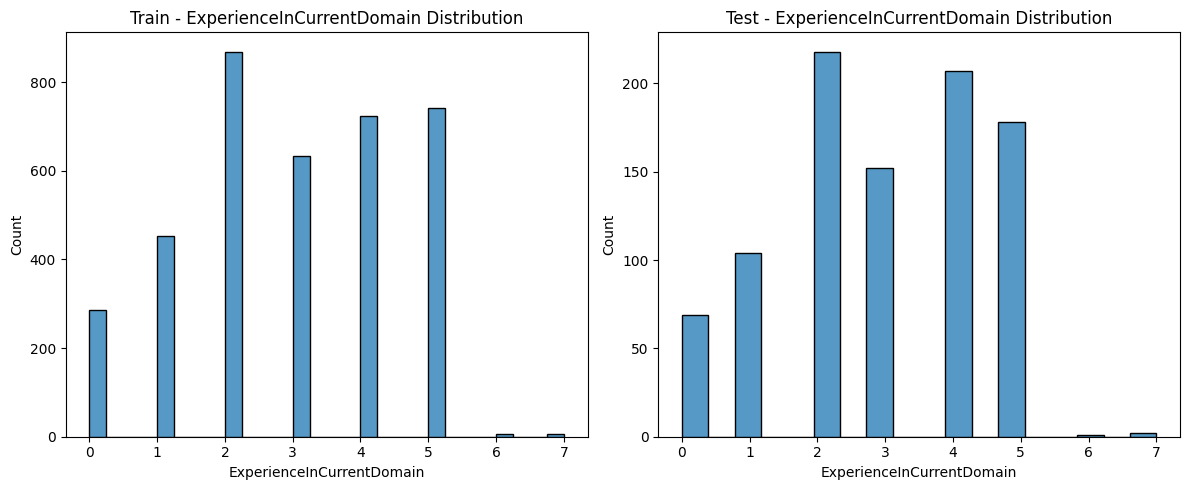

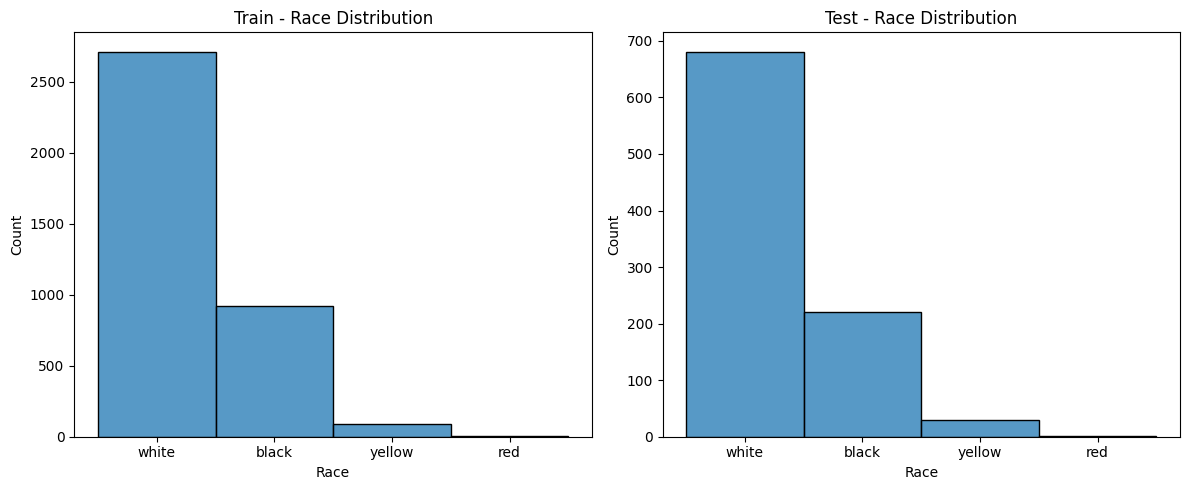

In [76]:
# Define the features for EDA (excluding 'id')
features = ['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age',
            'Gender', 'EverBenched', 'ExperienceInCurrentDomain', 'Race']

# Plotting histograms for each feature
for feature in features:
    plt.figure(figsize=(12, 5))

    # Plot for Train dataset
    plt.subplot(1, 2, 1)
    sns.histplot(X_train[feature])#, kde=True)
    plt.title(f'Train - {feature} Distribution')

    # Plot for Test dataset
    plt.subplot(1, 2, 2)
    sns.histplot(X_test[feature])#, kde=True)
    plt.title(f'Test - {feature} Distribution')

    plt.tight_layout()
    plt.show()


##Preprocess Pipeline
Currently it is without lines removal due to the fact the y_train must be aligned to X_train_cleaned.

Lines with missing data will be handled externally, while aligining between X_train and y_train

###The Pipline

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Custom transformer for creating the Tenure feature
class TenureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['Tenure'] = 2023 - X['JoiningYear']
        return X[['Tenure']]

# Custom transformer to capture indices (in order to align y_train to preprocessed X_train)
class IndexKeeper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.indices_ = X.index  # Capture the indices
        return X

# Custom transformer for removing rows with missing data
class MissingDataRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.dropna()

class CustomMissingDataRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.retained_indices_ = None

    def fit(self, X, y=None):
        # Assuming missing values are handled here
        self.retained_indices_ = X.dropna().index
        return self

    def transform(self, X):
        return X.dropna()

# Define the columns
categorical_features = ['Education', 'City', 'Gender', 'EverBenched', 'Race']
ordinal_features = ['PaymentTier']
numerical_features = ['Age', 'ExperienceInCurrentDomain']

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[[1, 2, 3]])
numerical_transformer = StandardScaler()

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('num', numerical_transformer, numerical_features),
        ('tenure', TenureTransformer(), ['JoiningYear'])
    ],
    remainder='drop',  # Drops other columns not specified in transformers
    sparse_threshold = 0

)
# preprocessor.set_output(transform="pandas")



# Create the full pipeline
preprocessing_pipeline = Pipeline(steps=[
    # ('custom_missing_data_remover', CustomMissingDataRemover()),
    # ('index_keeper', IndexKeeper()),
    # ('remove_missing', MissingDataRemover()),
    ('preprocessor', preprocessor)
])

###Remove lines with Missing Data

In [78]:
# Identify rows with missing data in X_train
rows_with_missing_data = X_train.isnull().any(axis=1)

# Remove these rows from both X_train and y_train
X_train_cleaned = X_train[~rows_with_missing_data]
y_train_cleaned = y_train[~rows_with_missing_data]

In [79]:
X_train_cleaned.tail()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
Unnamed: 0,,,,,,,,,,
3335,Bachelors,2016,Bangalore,3,38.0,Female,No,0,3335,white
1099,Masters,2017,Pune,2,29.0,Male,No,5,1099,white
2514,Bachelors,2016,Pune,3,31.0,Male,No,5,2514,black
3606,Bachelors,2013,Pune,2,36.0,Female,No,3,3606,black
2575,Bachelors,2013,Bangalore,3,31.0,Male,No,2,2575,white


In [80]:
y_train_cleaned.tail()

,LeaveOrNot
Unnamed: 0,
3335,0
1099,1
2514,0
3606,1
2575,0


####Present rows with missing data in X_train

In [81]:
missing_data_rows = X_train.loc[rows_with_missing_data]
missing_data_rows

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
Unnamed: 0,,,,,,,,,,
0,Bachelors,2017,Bangalore,3,NaN,NaN,No,0,0,white
1,Bachelors,2013,Pune,1,NaN,NaN,No,3,1,white


In [82]:
# Remove these rows from both X_train and y_train
X_train_cleaned = X_train[~rows_with_missing_data]
y_train_cleaned = y_train[~rows_with_missing_data]

###Apply Preprocess Pipline on X_train_cleaned

In [83]:
# Fit the pipeline to X_train
X_train_processed = preprocessing_pipeline.fit_transform(X_train_cleaned)

***bold text***###Examine X_train after Preprocessing

In [84]:
# Construct feature names
categorical_features = ['Education', 'City', 'Gender', 'EverBenched', 'Race']
one_hot_features = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
ordinal_features = ['PaymentTier']
standard_scaled_features = ['Age', 'ExperienceInCurrentDomain']
custom_features = ['Tenure']

# Combine all feature names
all_feature_names = list(one_hot_features) + ordinal_features + standard_scaled_features + custom_features

# Convert the processed data to a DataFrame with feature names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)



In [85]:
one_hot_features

array(['Education_Bachelors', 'Education_Masters', 'Education_PHD',
       'City_Bangalore', 'City_New Delhi', 'City_Pune', 'Gender_Female',
       'Gender_Male', 'EverBenched_No', 'EverBenched_Yes', 'Race_black',
       'Race_red', 'Race_white', 'Race_yellow'], dtype=object)

In [86]:
X_train_processed_df.describe()

,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,Race_black,Race_red,Race_white,Race_yellow,PaymentTier,Age,ExperienceInCurrentDomain,Tenure
count,3720.000000,3720.00000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3.720000e+03,3.720000e+03,3720.000000
mean,0.773387,0.18871,0.037903,0.477957,0.247312,0.274731,0.403763,0.596237,0.895968,0.104032,0.246774,0.001075,0.728495,0.023656,1.696774,-1.614002e-16,1.308392e-16,7.924462
std,0.418696,0.39133,0.190988,0.499581,0.431508,0.446439,0.490717,0.490717,0.305343,0.305343,0.431192,0.032778,0.444796,0.151995,0.558000,1.000134e+00,1.000134e+00,1.864874
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.631329e+00,-1.855879e+00,5.000000
25%,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-8.083360e-01,-5.753691e-01,6.000000
50%,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,-3.968396e-01,6.488608e-02,8.000000
75%,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,6.319014e-01,7.051413e-01,9.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.483635e+00,2.625907e+00,11.000000


#First Run of Model

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data to train and test
X_train, X_val, y_train, y_val = train_test_split(X_train_processed, y_train_cleaned, test_size=0.2, random_state=42)

# Initialize models
dt = DecisionTreeClassifier()
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
svc = SVC()
knn = KNeighborsClassifier()
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Train each model
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)
svc.fit(X_train, y_train)
knn.fit(X_train, y_train)
ada.fit(X_train, y_train)
dt.fit(X_train, y_train)

# Define a function to evaluate models
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    return accuracy, precision, recall, f1

# Evaluate each model
log_reg_metrics = evaluate_model(log_reg, X_val, y_val)
random_forest_metrics = evaluate_model(random_forest, X_val, y_val)
gradient_boosting_metrics = evaluate_model(gradient_boosting, X_val, y_val)
svc_metrics = evaluate_model(svc, X_val, y_val)
knn_metrics = evaluate_model(knn, X_val, y_val)
ada_metrics = evaluate_model(ada, X_val, y_val)

# Present metrics side-by-side
model_performance = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "Support Vector Machine", "K-Nearest Neighbours", "ADA Boost","Decision_tree"],
    "Accuracy":  [log_reg_metrics[0], random_forest_metrics[0], gradient_boosting_metrics[0], svc_metrics[0], knn_metrics[0], ada_metrics[0]],
    "Precision": [log_reg_metrics[1], random_forest_metrics[1], gradient_boosting_metrics[1], svc_metrics[1], knn_metrics[1], ada_metrics[1]],
    "Recall":    [log_reg_metrics[2], random_forest_metrics[2], gradient_boosting_metrics[2], svc_metrics[2], knn_metrics[2], ada_metrics[2]],
    "F1 Score":  [log_reg_metrics[3], random_forest_metrics[3], gradient_boosting_metrics[3], svc_metrics[3], knn_metrics[3], ada_metrics[3]]
})

model_performance.set_index('Model')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.725806,0.734568,0.425000,0.538462
Random Forest,0.810484,0.788382,0.678571,0.729367
Gradient Boosting,0.849462,0.892523,0.682143,0.773279
Support Vector Machine,0.779570,0.808511,0.542857,0.649573
K-Nearest Neighbours,0.810484,0.814480,0.642857,0.718563
ADA Boost,0.793011,0.754032,0.667857,0.708333


In [88]:
type(log_reg_metrics)

tuple

#Addressing the Class Imbalance

##Supporting Function (sort of pipeline)
The *train_and_evaluate_model*s function is designed to train and evaluate four different machine learning models: Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Machine.

It accepts training and validation data sets, along with a **boolean parameter** *balance_classes*s to toggle class balancing strategies. **If *balance_classes*s is set to True, the function applies class balancing techniques** like setting *class_weight='balanced'*s for applicable models and using *sample_weight*s for Gradient Boosting.

The function returns a DataFrame summarizing the performance metrics (Accuracy, Precision, Recall, F1 Score) of each model, facilitating easy comparison of their effectiveness under balanced or unbalanced class conditions.

In [89]:
from sklearn.utils.class_weight import compute_sample_weight

def train_and_evaluate_models(X_train, y_train, X_val, y_val, balance_classes=True):
    # Compute sample weights for handling class imbalance only if balance_classes is True
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) if balance_classes else None

    # Initialize models with or without class balancing
    log_reg = LogisticRegression(class_weight='balanced' if balance_classes else None)
    random_forest = RandomForestClassifier(class_weight='balanced' if balance_classes else None)
    gradient_boosting = GradientBoostingClassifier()
    svc = SVC(class_weight='balanced' if balance_classes else None)

    # Dictionary to hold evaluation metrics
    metrics = {}

    # Train and evaluate Logistic Regression
    log_reg.fit(X_train, y_train)
    metrics['Logistic Regression'] = evaluate_model(log_reg, X_val, y_val)

    # Train and evaluate Random Forest
    random_forest.fit(X_train, y_train)
    metrics['Random Forest'] = evaluate_model(random_forest, X_val, y_val)

    # Train and evaluate Gradient Boosting with sample weights if balance_classes is True
    if balance_classes:
        gradient_boosting.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        gradient_boosting.fit(X_train, y_train)
    metrics['Gradient Boosting'] = evaluate_model(gradient_boosting, X_val, y_val)

    # Train and evaluate SVC
    svc.fit(X_train, y_train)
    metrics['Support Vector Machine'] = evaluate_model(svc, X_val, y_val)

    # Create a DataFrame for metrics
    model_performance = pd.DataFrame.from_dict(metrics, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

    return model_performance

In [90]:
def evaluate_change(model_performance_before, model_performance_after):
  # Calculate the percentage change
  change_percentage = (model_performance_after - model_performance_before) / model_performance_before * 100

  # Display the changes
  return change_percentage

##Class Weights

###Unbablanced (same results as before)

In [91]:
model_performance_unbalanced = train_and_evaluate_models(X_train, y_train, X_val, y_val, balance_classes=False)
model_performance_unbalanced

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-89-299b946609dc>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_trai

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.725806,0.734568,0.425000,0.538462
Random Forest,0.813172,0.800000,0.671429,0.730097
Gradient Boosting,0.849462,0.892523,0.682143,0.773279
Support Vector Machine,0.779570,0.808511,0.542857,0.649573


###Bablanced (same results as before)

In [92]:
model_performance_balanced = train_and_evaluate_models(X_train, y_train, X_val, y_val, balance_classes=True)
model_performance_balanced

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-89-299b946609dc>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_trai

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.709677,0.600629,0.682143,0.638796
Random Forest,0.810484,0.781377,0.689286,0.732448
Gradient Boosting,0.822581,0.782443,0.732143,0.756458
Support Vector Machine,0.752688,0.649068,0.746429,0.694352


In [93]:
evaluate_change(model_performance_unbalanced, model_performance_balanced)

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,-2.222222,-18.233709,60.504202,18.633540
Random Forest,-0.330579,-2.327935,2.659574,0.321975
Gradient Boosting,-3.164557,-12.333640,7.329843,-2.175383
Support Vector Machine,-3.448276,-19.720497,37.500000,6.893688


##SMOTE

In [94]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Now X_train_smote and y_train_smote are the resampled data
model_performance_Smote_unbalanced = train_and_evaluate_models(X_train_smote, y_train_smote, X_val, y_val, balance_classes=False)
model_performance_Smote_unbalanced

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-89-299b946609dc>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_trai

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.708333,0.599369,0.678571,0.636516
Random Forest,0.814516,0.781746,0.703571,0.740602
Gradient Boosting,0.842742,0.838174,0.721429,0.775432
Support Vector Machine,0.756720,0.656151,0.742857,0.696817


In [95]:
evaluate_change(model_performance_unbalanced, model_performance_Smote_unbalanced)

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,-2.407407,-18.405217,59.663866,18.210098
Random Forest,0.165289,-2.281746,4.787234,1.438770
Gradient Boosting,-0.791139,-6.089375,5.759162,0.278361
Support Vector Machine,-2.931034,-18.844430,36.842105,7.273208


In [96]:
model_performance_Smote_balanced = train_and_evaluate_models(X_train_smote, y_train_smote, X_val, y_val, balance_classes=True)
model_performance_Smote_balanced

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-89-299b946609dc>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_trai

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.708333,0.599369,0.678571,0.636516
Random Forest,0.811828,0.789256,0.682143,0.731801
Gradient Boosting,0.842742,0.838174,0.721429,0.775432
Support Vector Machine,0.756720,0.656151,0.742857,0.696817


In [97]:
evaluate_change(model_performance_unbalanced, model_performance_Smote_balanced)

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,-2.407407,-18.405217,59.663866,18.210098
Random Forest,-0.165289,-1.342975,1.595745,0.233350
Gradient Boosting,-0.791139,-6.089375,5.759162,0.278361
Support Vector Machine,-2.931034,-18.844430,36.842105,7.273208


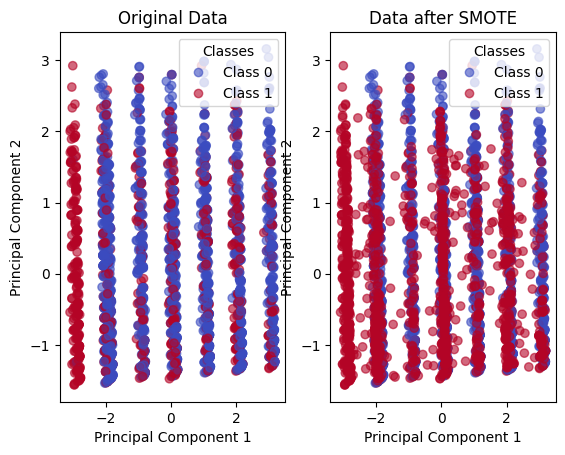

In [98]:
from sklearn.decomposition import PCA

# Applying PCA to reduce the data to two dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Transforming the SMOTE-resampled data with PCA
X_train_smote_pca = pca.transform(X_train_smote)

# Converting y_train(s) to 1D arrays for plotting
y_train_array = y_train.squeeze()
y_train_smote_array = y_train_smote.squeeze()

# Original Data Plot
plt.subplot(1, 2, 1)
scatter_original = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_array, cmap='coolwarm', alpha=0.6)
plt.title('Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter_original.legend_elements()[0], title="Classes", labels=['Class 0', 'Class 1'])

# Data after SMOTE Plot
plt.subplot(1, 2, 2)
scatter_smote = plt.scatter(X_train_smote_pca[:, 0], X_train_smote_pca[:, 1], c=y_train_smote_array, cmap='coolwarm', alpha=0.6)
plt.title('Data after SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter_smote.legend_elements()[0], title="Classes", labels=['Class 0', 'Class 1'])

plt.show()


#Models Tweaking

In [99]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

##Generic Report

In [100]:
from sklearn.metrics import confusion_matrix, classification_report

def report(clf, X, y):
    acc = accuracy_score(y_true=y,
                         y_pred=clf.predict(X))

    print("\n\n=== Confusion matrix  ===\n")
    cm = pd.DataFrame(confusion_matrix(y_true=y,
                                       y_pred=clf.predict(X)),
                      index=clf.classes_,
                      columns=clf.classes_)
    print(cm)
    print("\n\n=== Classification report  ===\n")
    rep = classification_report(y_true=y,
                                y_pred=clf.predict(X))
    print(rep)

##Hyperparameters

###Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

log_reg_pipeline = ImbPipeline([
    # ('preprocessing', preprocessing_pipeline),  # Replace with your preprocessing pipeline
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid_log_reg = {
    'classifier__C': range(10, 101, 10), #[0.1, 1, 10], #[0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__class_weight': [None, 'balanced'],
    'smote': [None, SMOTE(random_state=42)]
}

# grid_search_log_reg = GridSearchCV(log_reg_pipeline, param_grid_log_reg, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
# grid_search_log_reg.fit(X_train, y_train)

# log_reg_cv_scores = cross_val_score(grid_search_log_reg.best_estimator_, X_train, y_train, cv=5, scoring='f1')


In [102]:
grid_search_log_reg = GridSearchCV(log_reg_pipeline, param_grid_log_reg, cv=5, scoring='f1', n_jobs=-1)#, error_score='raise', verbose=3)
grid_search_log_reg.fit(X_train, y_train.values.ravel())#y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': range(10, 101, 10),
                         'classifier__class_weight': [None, 'balanced'],
                         'smote': [None, SMOTE(random_state=42)]},
             scoring='f1')

In [103]:
best_parameters = grid_search_log_reg.best_params_

best_parameters

{'classifier__C': 40,
 'classifier__class_weight': None,
 'smote': SMOTE(random_state=42)}

In [104]:
log_reg_cv_scores = cross_val_score(grid_search_log_reg.best_estimator_, X_train, y_train.values.ravel(), cv=5, scoring='f1')
log_reg_cv_scores.mean()

0.5883351820766578

In [105]:
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(grid_search_log_reg.best_estimator_, X_train, y_train.values.ravel(), cv=5, scoring=scoring_metrics)

for key, value in cv_results.items():
    print(f"{key}: {value.mean():.2f}")

fit_time: 0.18
score_time: 0.01
test_accuracy: 0.69
test_precision: 0.54
test_recall: 0.64
test_f1: 0.59


In [106]:
cv_results

{'fit_time': array([0.20169234, 0.17263818, 0.16073108, 0.2053442 , 0.17632747]),
 'score_time': array([0.00825477, 0.00788641, 0.01462436, 0.01421714, 0.00796819]),
 'test_accuracy': array([0.69295302, 0.6907563 , 0.70420168, 0.6907563 , 0.67563025]),
 'test_precision': array([0.54693878, 0.54054054, 0.56118143, 0.54468085, 0.52564103]),
 'test_recall': array([0.65048544, 0.68292683, 0.64878049, 0.62439024, 0.6       ]),
 'test_f1': array([0.59423503, 0.60344828, 0.60180995, 0.58181818, 0.56036446])}

In [107]:
print(report(grid_search_log_reg, X_train, y_train))



=== Confusion matrix  ===

      0    1
0  1419  531
1   377  649


=== Classification report  ===

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1950
           1       0.55      0.63      0.59      1026

    accuracy                           0.69      2976
   macro avg       0.67      0.68      0.67      2976
weighted avg       0.71      0.69      0.70      2976

None


In [108]:
import pandas as pd

# Assuming 'grid_search' is your GridSearchCV object
cv_results = grid_search_log_reg.cv_results_

# Convert to DataFrame
results_df = pd.DataFrame(cv_results)

# Filter the columns to include only those relevant for parameter combinations and mean test scores
filtered_results_df = results_df.filter(regex='(param_.*)|(mean_test_score)')

# Optionally, sort the DataFrame based on the scores
sorted_results_df = filtered_results_df.sort_values(by='mean_test_score', ascending=False)

sorted_results_df


,param_classifier__C,param_classifier__class_weight,param_smote,mean_test_score
15,40,balanced,SMOTE(random_state=42),0.588723
13,40,None,SMOTE(random_state=42),0.588723
37,100,None,SMOTE(random_state=42),0.588471
39,100,balanced,SMOTE(random_state=42),0.588471
7,20,balanced,SMOTE(random_state=42),0.588365
23,60,balanced,SMOTE(random_state=42),0.588365
21,60,None,SMOTE(random_state=42),0.588365
5,20,None,SMOTE(random_state=42),0.588365
17,50,None,SMOTE(random_state=42),0.588090
19,50,balanced,SMOTE(random_state=42),0.588090
